# Kratak izvještaj rezultata projekta iz predmeta Digitalni procesori signala

## Student: Aleksandar Petoš, 3024/2023

In [1]:
USE_WIDGETS = True

def importEssentialLibs(USE_WIDGETS):
    import numpy as np
    if USE_WIDGETS:
        %matplotlib widget
    else:
        %matplotlib inline
    import matplotlib as mpl
    mpl.rc('text', usetex = True)
    mpl.rc('font', family = 'serif', size = 18)
    import matplotlib.pyplot as plt
    
    return np, mpl, plt

np, mpl, plt = importEssentialLibs(USE_WIDGETS)
import scipy.fft as fft
import IPython
from IPython.display import Markdown
from scipy.io import wavfile
from scipy.signal import chirp, spectrogram
import scipy.signal as signal
import pickle 
import scipy.io as sio
from scipy.signal import butter, lfilter, freqz
from scipy.signal import firwin, convolve
from fxpmath import Fxp

# Određivanje daljine objekata iz signala sonara na DSP platformi

# 1.1 Python

## Učitavanje neophodnih fajlova iz MATLAB-a

In [2]:
matContentsProject = sio.loadmat('signals/sonar_signals.mat')
rxChirp = matContentsProject['rxChirp'].squeeze()
txChirp = matContentsProject['txChirp'].squeeze()
fs = 200000

## Korisno za prikazivanje spektrograma

In [3]:
def plot_spectrogram(title, x, fs):
    f1 = 60000
    f0 = 20000
    T = 0.01
    beta = (f1 - f0) / T
    c = 1500 # ~speed of sound in water
    Nwin = 128            
    window = signal.windows.triang(Nwin) 
    NFFT = Nwin                          # >= od nperseg = 256 po default
    fMaxShow = fs//2
    fMaxIndex = NFFT*fMaxShow//fs
    
    fig, axs = plt.subplots(figsize = [10, 5])
    plt.subplots_adjust(bottom=0.15, left = 0.15)
    ff, tt, Sxx = signal.spectrogram(x, fs=fs, window = window, noverlap = None, nfft=NFFT, nperseg = Nwin,
                                     return_onesided=True, scaling='spectrum', mode='complex') 
    
    dd = ff*c/(2*beta)

    plt.pcolormesh(tt, ff[:fMaxIndex], 20*np.log10(abs(Sxx[:][:fMaxIndex])), shading='nearest') #cmap='gray_r')
    plt.title(title)
    plt.xlabel(r'$t$ [s]')
    plt.ylabel(r'$f$ [Hz]')
    #plt.ylabel(r'$d$ [m]')
    plt.grid()


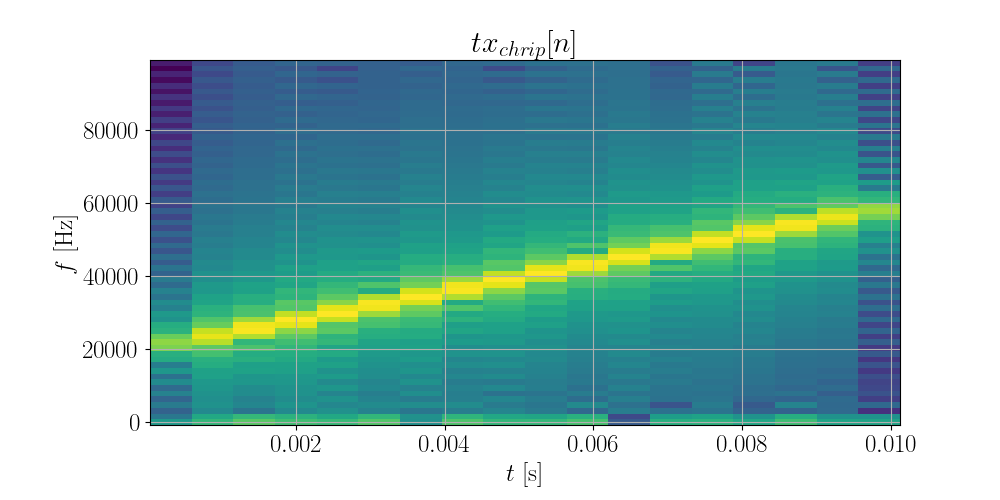

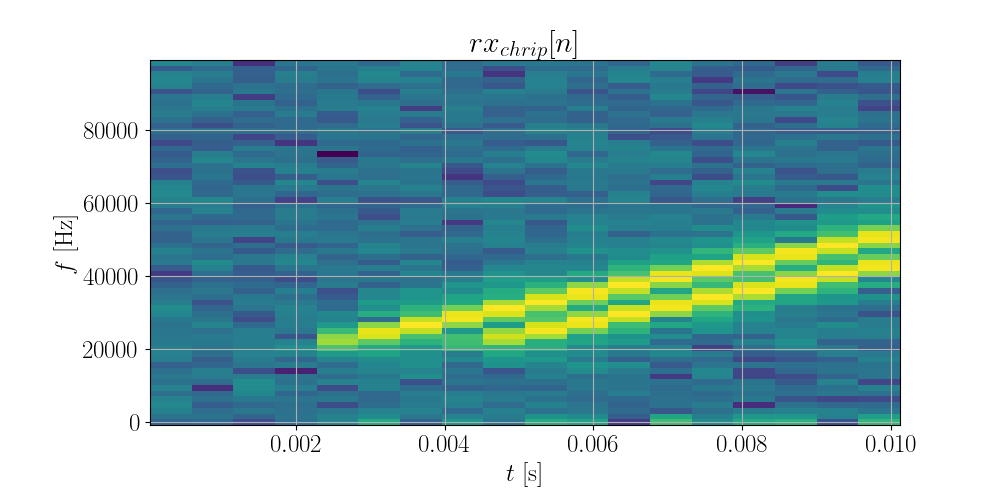

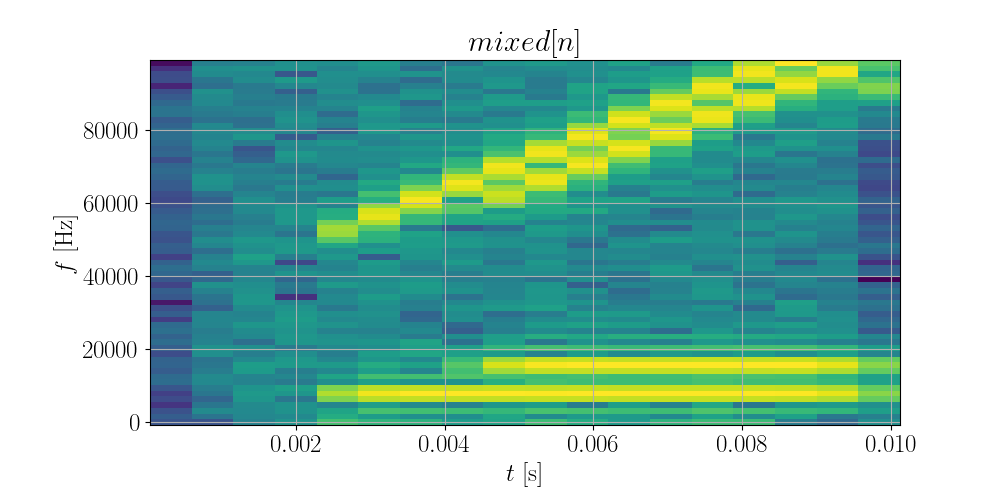

In [4]:
plot_spectrogram(r'$tx_{chrip}[n]$', txChirp, 200000)
plot_spectrogram(r'$rx_{chrip}[n]$', rxChirp, 200000)
plot_spectrogram(r'$mixed[n]$', txChirp*rxChirp, 200000)

## Funkcija u Python-u koja projektuje NF filtar

In [5]:
# Function to create an FIR low-pass filter
def fir_lowpass(cutoff, fs, num_taps=50):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    taps = firwin(num_taps, normal_cutoff, window='hamming')
    return taps
decimation_filter_python = fir_lowpass(20000, fs, num_taps=50)

## Može se koristiti i filtar za decimaciju dva puta iz MATLAB-a a koji je generisan putem filterDesigner-a

In [6]:
matContentsFilter = sio.loadmat('signals/decimation_filter.mat')
decimation_filter_matlab = matContentsFilter['filter'].squeeze()[:-1]

## Za realizaciju polifaznog filtra potrebne su sekcije koje se sastoje od istog broja elemenata, zato se uzima paran broj koeficijenata filtra

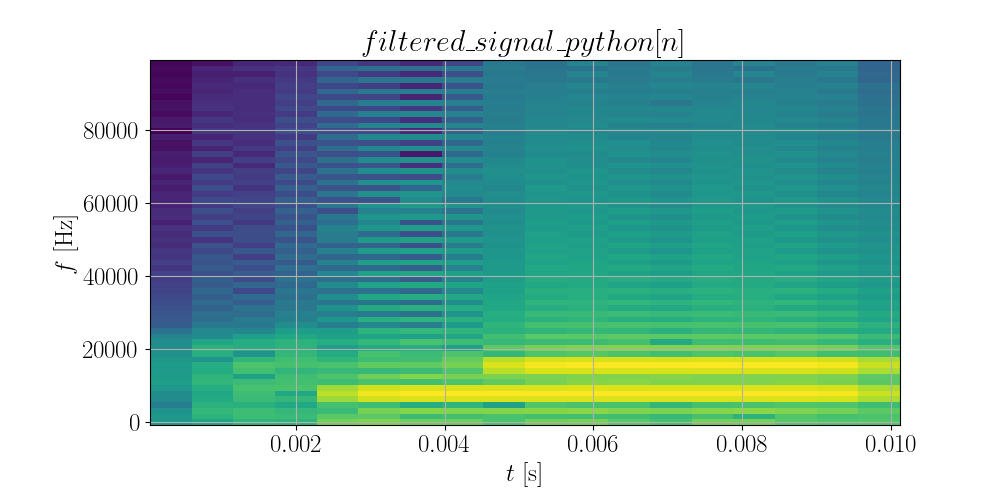

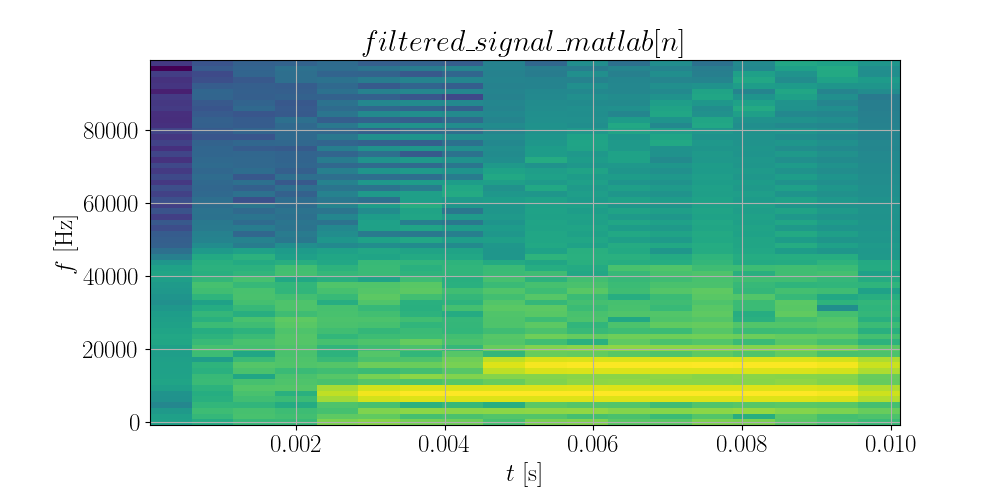

In [7]:
filtered_signal_python = lfilter(decimation_filter_python, 1.0, txChirp*rxChirp)
filtered_signal_matlab = lfilter(decimation_filter_matlab, 1.0, txChirp*rxChirp)
plot_spectrogram(r'$filtered\_signal\_python[n]$', filtered_signal_python, 200000)
plot_spectrogram(r'$filtered\_signal\_matlab[n]$', filtered_signal_matlab, 200000)

## Amplitudska i fazna karakteristika korišćenog filtra iz Python-a

<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_4470/1655922834.py:10: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_ylabel('$|H(j\omega)|$')
/tmp/ipykernel_4470/1655922834.py:11: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_xlabel('$\omega$');
/tmp/ipykernel_4470/1655922834.py:17: SyntaxWarning: invalid escape sequence '\o'
  ax3.set_ylabel('$X_p(j\omega)$')
/tmp/ipykernel_4470/1655922834.py:18: SyntaxWarning: invalid escape sequence '\o'
  ax3.set_xlabel('$\omega$');


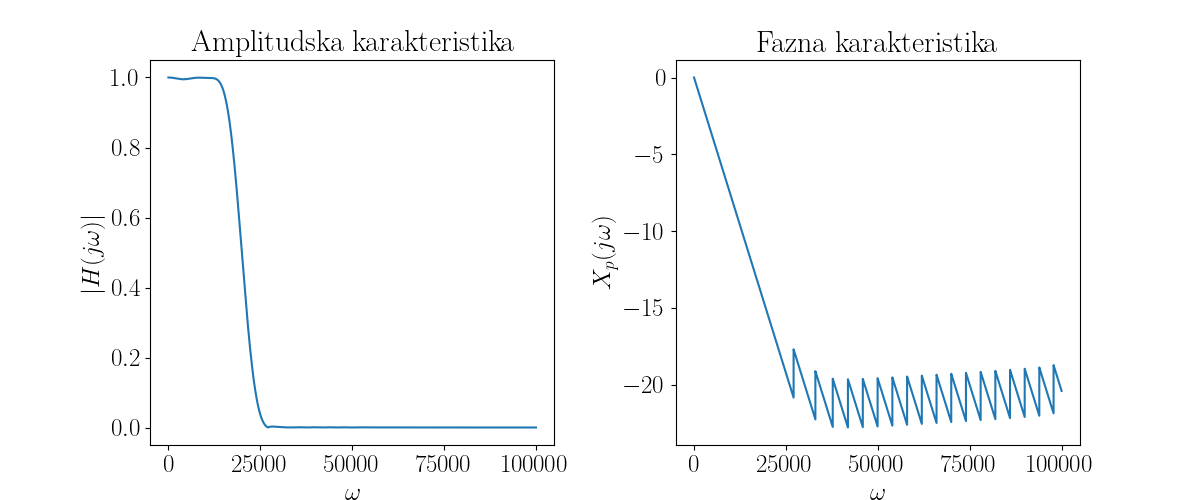

In [8]:
fig = plt.figure(figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
# Frekvencijska karakteristika
w, h = freqz(decimation_filter_python, 1, worN=fs//2)
Ha = abs(h)
    
ax2 = fig.add_subplot(1,2,1)
ax2.plot(0.5*fs*w/np.pi, Ha)
ax2.set_title('Amplitudska karakteristika')
ax2.set_ylabel('$|H(j\omega)|$')
ax2.set_xlabel('$\omega$');


ax3 = fig.add_subplot(1,2,2)
ax3.plot(0.5*fs*w/np.pi, np.unwrap(np.angle(h)))
ax3.set_title('Fazna karakteristika')
ax3.set_ylabel('$X_p(j\omega)$')
ax3.set_xlabel('$\omega$');


## Funkcije koje implementiraju polifazne filtre, gdje su pojedinačni filtri realizovani kao direktni i direktni-transponovani

In [9]:
def polyphase_decimate_fir_direct(input_signal, nf_filter, factor):
    x = input_signal
    # Split the coefficients of NF filter into polyphase components
    num_phases = factor
    polyphase_sections = [nf_filter[i::num_phases] for i in range(num_phases)]
    h0 = polyphase_sections[0]
    h1 = polyphase_sections[1]
    
    M0 = len(h0)
    M1 = len(h1)
    delayLine0 = np.zeros(M0)
    delayLine1 = np.zeros(M1)
    output_signal = np.zeros(round(len(x)/num_phases))
    y0 = np.zeros(len(x))
    y1 = np.zeros(len(x))
    i = 0
    temp = 0
    for n in range(len(x)):
        if (n % 2 == 0):
            delayLine0[1:] = delayLine0[:M0-1]
            delayLine0[0] = x[n]
            for m in range(M0):
                y0[n] += h0[m]*delayLine0[m]
            output_signal[i] = y0[n] + temp
            i = i + 1
        else:
            delayLine1[1:] = delayLine1[:M1-1]
            delayLine1[0] = x[n]
            for m in range(M1):
                y1[n] += h1[m]*delayLine1[m]
            temp = y1[n]
    return output_signal

def polyphase_decimate_fir_direct_transposed(input_signal, nf_filter, factor):
    x = input_signal
    # Split the coefficients of NF filter into polyphase components
    num_phases = factor
    polyphase_sections = [nf_filter[i::num_phases] for i in range(num_phases)]
    h0 = polyphase_sections[0]
    h1 = polyphase_sections[1]
    
    M0 = len(h0)
    M1 = len(h1)
    
    mul0 = np.zeros(M0)
    mul1 = np.zeros(M1)
    reg0 = np.zeros(M0)
    reg1 = np.zeros(M1)
    y0 = np.zeros(len(x))
    y1 = np.zeros(len(x))
    
    temp = 0
    output_signal = np.zeros(round(len(x)/num_phases))

    i = 0

    for n in range(len(x)):
        if (n % 2 == 0):
            for j in range(M0):
                mul0[j] = h0[j] * x[n]
            y0[n] = mul0[0] + reg0[0]
            output_signal[i] = y0[n] + temp
            i = i + 1
            # Side effect, prepare for next
            for k in range(0, M0-1):
                reg0[k] = mul0[k+1] + reg0[k+1]
           
        else:
            for j in range(M1):
                mul1[j] = h1[j] * x[n]
            y1[n] = mul1[0] + reg1[0]
            temp = y1[n]
            
            # Side effect, prepare for next
            for k in range(0, M1-1):
                reg1[k] = mul1[k+1] + reg1[k+1]
            
    return output_signal    

## Rezultat decimacije proizvoda predajnog i prijemnih chirp signala

In [10]:
mixed_signal = rxChirp*txChirp

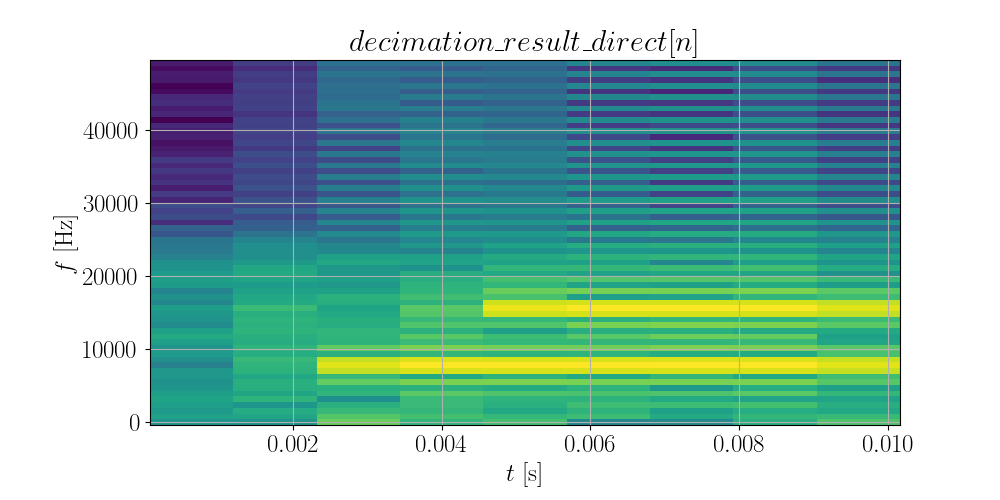

In [11]:
rez1 = polyphase_decimate_fir_direct(mixed_signal, decimation_filter_python, 2)
plot_spectrogram(r'$decimation\_result\_direct[n]$', rez1, 100000)

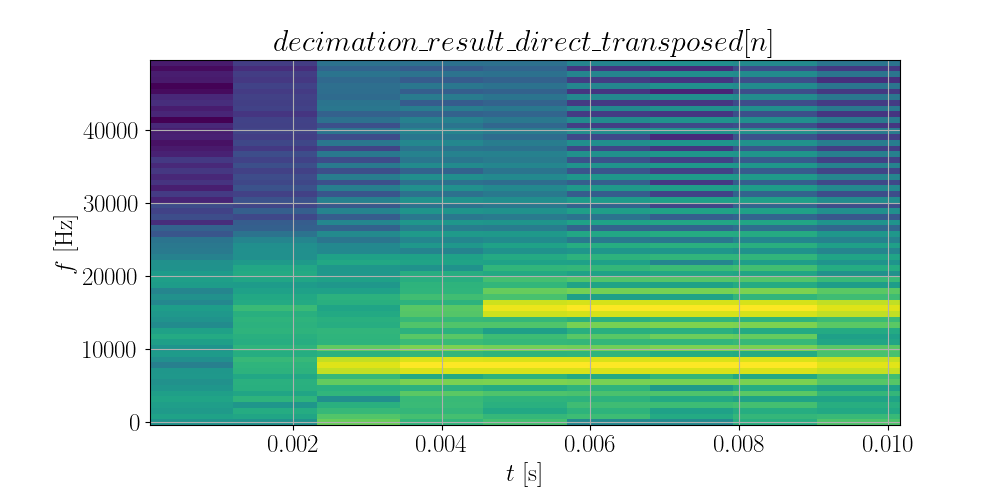

In [12]:
rez2 = polyphase_decimate_fir_direct_transposed(mixed_signal, decimation_filter_python, 2)
plot_spectrogram(r'$decimation\_result\_direct\_transposed[n]$', rez2, 100000)

## Razlika u realizacijama

In [13]:
error = rez1-rez2
print(np.sum(abs(error)))

4.2890358861330874e-14


## Prikaz spektra originalnog i decimiranog signala

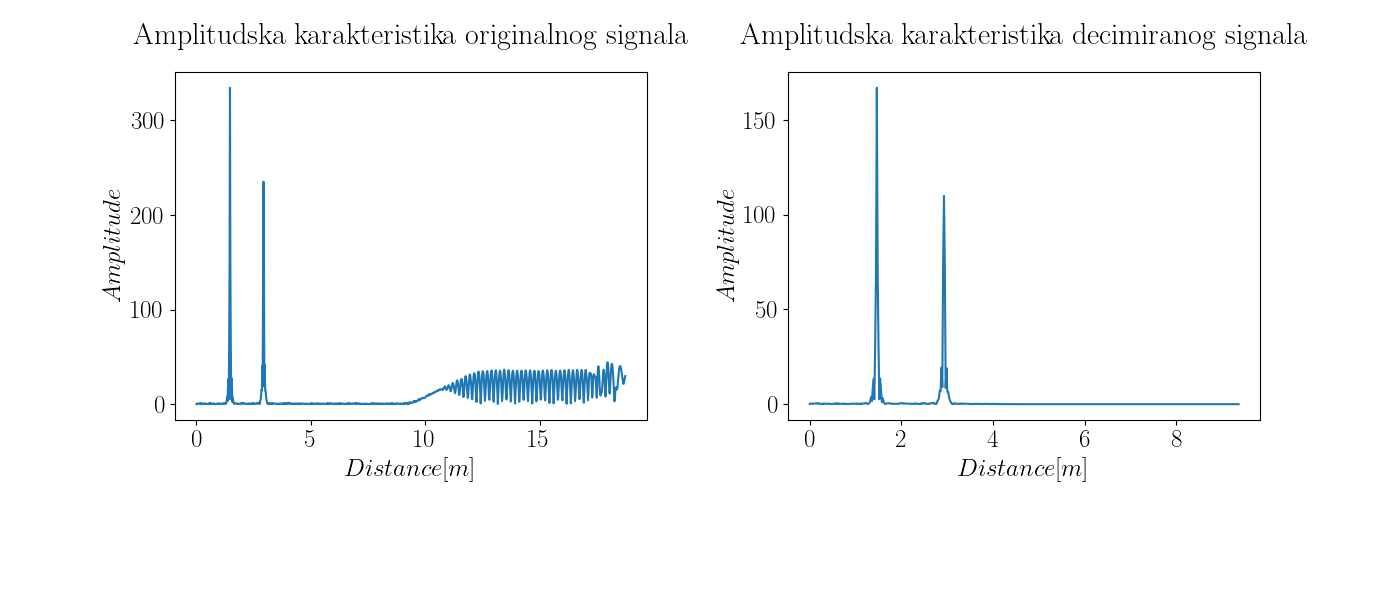

In [14]:
fig = plt.figure(figsize = (14,6))
plt.subplots_adjust(bottom=0.3,wspace = 0.3)


f1 = 60000
f0 = 20000
T = 0.01
beta = (f1 - f0) / T
c = 1500 # ~speed of sound in water


fft_result2 = np.fft.fft(mixed_signal)
frequencies2 = np.fft.fftfreq(len(fft_result2), 1/fs)
dd2 = frequencies2*c/(2*beta)

ax2 = fig.add_subplot(1,2,1)
ax2.plot(dd2[:len(dd2)//2], np.abs(fft_result2[:len(fft_result2)//2]))
ax2.set_title('Amplitudska karakteristika originalnog signala', pad = 20)
ax2.set_ylabel('$Amplitude$')
ax2.set_xlabel('$Distance[m]$');

fft_result1 = np.fft.fft(rez1)
fs_decimated = fs/2
frequencies1 = np.fft.fftfreq(len(fft_result1), 1/fs_decimated)
dd1 = frequencies1*c/(2*beta)

ax3 = fig.add_subplot(1,2,2)
ax3.plot(dd1[:len(dd1)//2], np.abs(fft_result1[:len(fft_result1)//2]))
ax3.set_title('Amplitudska karakteristika decimiranog signala', pad = 20)
ax3.set_ylabel('$Amplitude$')
ax3.set_xlabel('$Distance[m]$');



## Mete se nalaze na udaljenostima

In [20]:
abs_signal = np.abs(fft_result1[:len(fft_result1)//2])
# svi lokalni maksimumi
peaksPos = signal.argrelextrema(abs_signal, np.greater)[0]
# indeksi lokalnih maksimuma koji su najveci
maxPeaksPos = np.argsort(-abs_signal[peaksPos]) 
maxPeakIndex = peaksPos[maxPeaksPos][:2]
distance1 = frequencies1[maxPeakIndex[0]]*c/(2*beta)
distance2 = frequencies1[maxPeakIndex[1]]*c/(2*beta)
print(np.round(distance1,2),np.round(distance2,2))

1.46 2.93


# 1.2 Implementacija na DSP platformi 

## Upis signala i koeficijenata u .txt fajl kako bi se iskoristio za testiranje asemblerske funkcije

In [21]:
# Scaling signal
mixed_signal_scaled = mixed_signal#/(np.max([abs(min(mixed_signal)), abs(max(mixed_signal))]))
mixed_signal_scaled_fxp = (Fxp(mixed_signal_scaled, signed = True, n_word = 16, n_frac = 15, overflow = 'saturate', rounding = 'floor')).get_val()
mixed_signal_scaled_int = (np.round(mixed_signal_scaled_fxp*2**15)).astype(np.int16)

# # Open a file for writing input signal
# with open("input_signal_integer_for_asm.txt", "w") as output_file:
#     for i in range(len(mixed_signal_scaled_int)):
#         # Write to file
#         output_file.write(f"{(mixed_signal_scaled_int[i])}\n")


In [22]:
# Scaling coefficients
coefficients_scaled = decimation_filter_python#/(np.max([abs(min(decimation_filter_matlab)), abs(max(decimation_filter_matlab))]))
coefficients_scaled_fxp = (Fxp(coefficients_scaled, signed = True, n_word = 16, n_frac = 15, overflow = 'saturate', rounding = 'floor')).get_val()
coefficients_scaled_int = (np.round(coefficients_scaled_fxp*2**15)).astype(np.int16)

# # Open a file for writing coefficients
# with open("coefficients_integer_for_asm.txt", "w") as output_file:
#     for i in range(len(coefficients_scaled_int)):
#         # Write to file
#         output_file.write(f"{(coefficients_scaled_int[i])}\n")

## Nakon izvršavanja decimacije na DSP platformi funkcijom polyphaseDecimate.asm, rezultat je upisan u .txt fajl i poslat u ovu skriptu

## Učitavanje dobijenog signala i prikaz njegovog spektra

In [23]:
num_values = 0
NUM_ELEMENTS = 1024
rez_asm = np.zeros(NUM_ELEMENTS).astype(np.int16)
with open("output_signal_decimate_asm.txt", "r") as input_file:
    # Read from file
    for line in input_file:
        rez_asm[num_values] = int(line)
        num_values += 1
        if num_values == (NUM_ELEMENTS):
            break

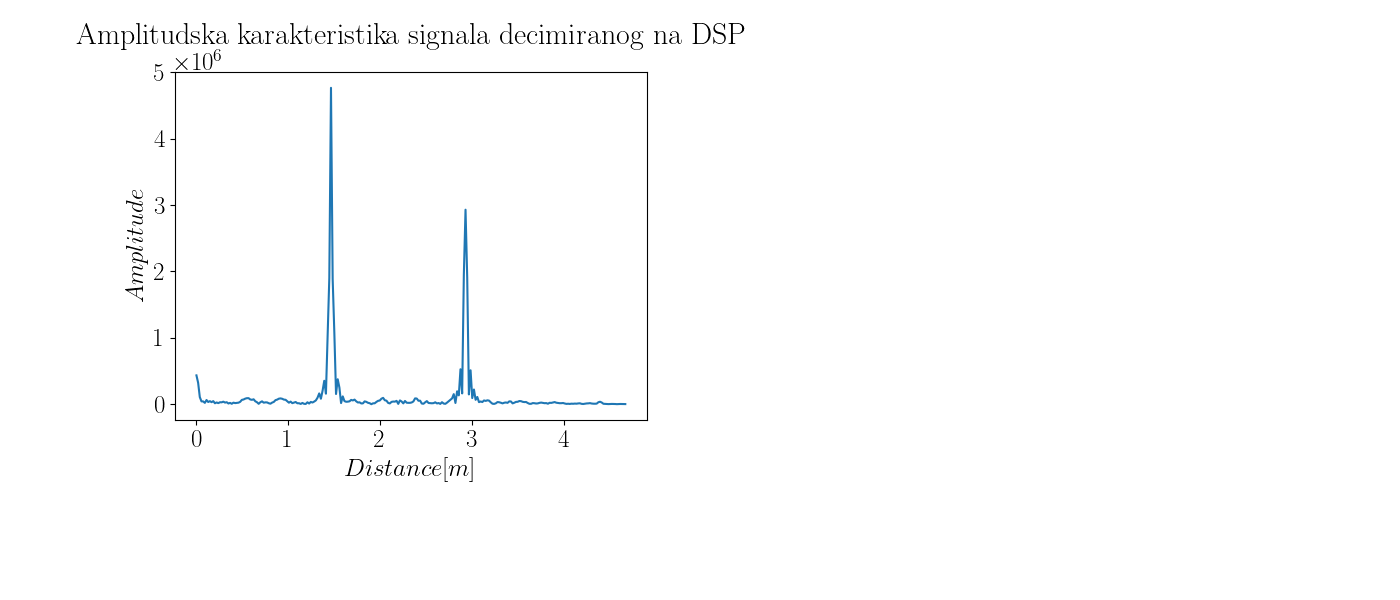

In [24]:
fig = plt.figure(figsize = (14,6))
plt.subplots_adjust(bottom=0.3, wspace = 0.3)
fs_decimated = fs/2
fft_result3 = np.fft.fft(rez_asm)
frequencies3 = np.fft.fftfreq(len(fft_result3), 1/fs_decimated)
dd3 = frequencies3*c/(2*beta)

ax2 = fig.add_subplot(1,2,1)
ax2.plot(dd3[:len(dd3)//4], np.abs(fft_result3[:len(fft_result3)//4]))
ax2.set_title('Amplitudska karakteristika signala decimiranog na DSP',pad = 20)
ax2.set_ylabel('$Amplitude$')
ax2.set_xlabel('$Distance[m]$');

## Isti .txt fajl se prosljeđuje u projekat peakDetector koji čita ovaj fajl i radi Furijeovu transformaciju pomoću ugrađenog FFT bloka na DSP platformi

## Nakon toga radi se određivanje pozicije maksimuma i skaliraju se pozicije tako da se dobiju udaljenosti

## Rezultat koji se dobija prikazan je na slici koja je data u prilogu

<img src="images/distances.PNG" width="800"/>

# Implementacija polifaznog filtra u VHDL-u

# 2.1 Python

## Potrebni signali za ovaj dio

In [25]:
h = np.array([-0.0136, -0.0139, 0.0254, 0.0523, -0.0124, -0.0880, 0.0252, 0.3169, \
              0.4807, 0.3169, 0.0252, -0.0880, -0.0124, 0.0523, 0.0254, -0.0139])
nh = np.arange(len(h))
# Definisanje ulaznog signala, zbir 2 sinusoide
F1 = 0.43
F2 = 0.1
N = 100
n = np.arange(N) 
x = np.sin(2*np.pi*F1*n) + np.sin(2*np.pi*F2*n)
x = x/(np.max([abs(min(x)), abs(max(x))]))


# overflow moze biti 'saturate' ili 'wrap'
overFlowMethod =  'saturate'


# rounding moze biti 'floor' , 'trunc' , 'around', 'ceil', 'fix'
roundingMethod = 'floor'

# x = x/(1-2**(-7)- (-1))
xFxp = Fxp(x, signed = True, n_word = 8, n_frac = 7, overflow = overFlowMethod, rounding = roundingMethod)
hFxp = Fxp(h, signed = True, n_word = 8, n_frac = 7, overflow = overFlowMethod, rounding = roundingMethod)

value_h = (hFxp.get_val())
value_x = (xFxp.get_val())


## Testiranje decimacije za generisani signal

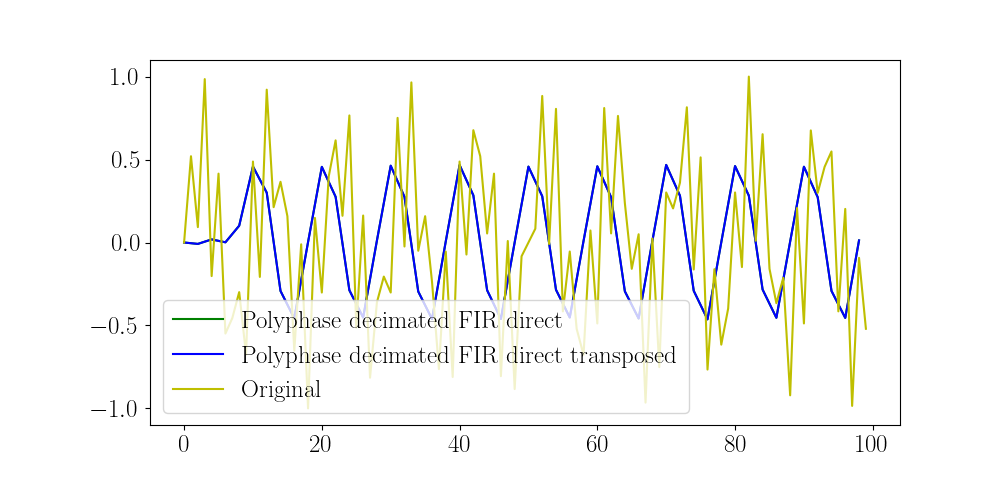

In [26]:
decimated_signal_my_fun_direct = polyphase_decimate_fir_direct(x, h, 2)
decimated_signal_my_fun_direct_transposed = polyphase_decimate_fir_direct_transposed(x, h, 2)

fig, axs = plt.subplots(figsize = [10, 5])
plt.subplots_adjust(bottom=0.15, left = 0.15)
plt.plot((n)[::2], decimated_signal_my_fun_direct, color = "g", label = "Polyphase decimated FIR direct")
plt.plot((n)[::2], decimated_signal_my_fun_direct_transposed, "b", label = "Polyphase decimated FIR direct transposed")
plt.plot(n, x, "y" , label = "Original");
plt.legend();

## Fixed-point analiza

## Polyphase decimate fir direct transposed fxp

In [27]:
def polyphase_decimate_fir_direct_transposed_fxp(input_signal, nf_filter, factor, outFxpFormat = None):
    x = input_signal
    # Split the coefficients of NF filter into polyphase components
    num_phases = factor
    polyphase_sections = [nf_filter[i::num_phases] for i in range(num_phases)]
    h0 = polyphase_sections[0]
    h1 = polyphase_sections[1]
    
    M0 = len(h0)
    M1 = len(h1)
    
    
    if outFxpFormat == None:
        y0 = Fxp(np.zeros(len(x)), signed = True, n_word = x.n_word + h0.n_word +int(np.ceil(np.log2(M0))), n_frac = x.n_frac + h0.n_frac)
        y1 = Fxp(np.zeros(len(x)), signed = True, n_word = x.n_word + h1.n_word +int(np.ceil(np.log2(M1))), n_frac = x.n_frac + h1.n_frac)

    else:
        y0 = Fxp(np.zeros(len(x)), dtype = outFxpFormat)
        y1 = Fxp(np.zeros(len(x)), dtype = outFxpFormat)

    y0.overflow = x.overflow
    y1.overflow = x.overflow

    y0.rounding = x.rounding
    y1.rounding = x.rounding

    mul0 = Fxp(np.zeros(M0), like = y0) 
    mul1 = Fxp(np.zeros(M1), like = y1) 
    
    reg0 = Fxp(np.zeros(M0), like = y0) 
    reg1 = Fxp(np.zeros(M1), like = y1)
    
    output_signal = Fxp(np.zeros(round(len(x)/num_phases)), like = y0)
    
    temp = Fxp(0, like = y1)
    i = 0

    for n in range(len(x)):
        if (n % 2 == 0):
            for j in range(M0):
                mul0[j] = Fxp(h0[j] * x[n], like = mul0)
            y0[n] = Fxp(mul0[0] + reg0[0], like = y0)
            output_signal[i] = Fxp(y0[n]+temp, like = output_signal)
            i = i + 1
            # Side effect, prepare for next
            for k in range(0, M0-1):
                reg0[k] = Fxp(mul0[k+1] + reg0[k+1], like = reg0)
           
        else:
            for j in range(M1):
                mul1[j] = Fxp(h1[j] * x[n], like = mul1)
            y1[n] = Fxp(mul1[0] + reg1[0], like = y1)
            temp = y1[n]
            
            # Side effect, prepare for next
            for k in range(0, M1-1):
                reg1[k] = Fxp(mul1[k+1] + reg1[k+1], like = reg1)
            
    return output_signal    

## Prikaz originalnih i zaokruženih koeficijenata filtra i ulaznog signala

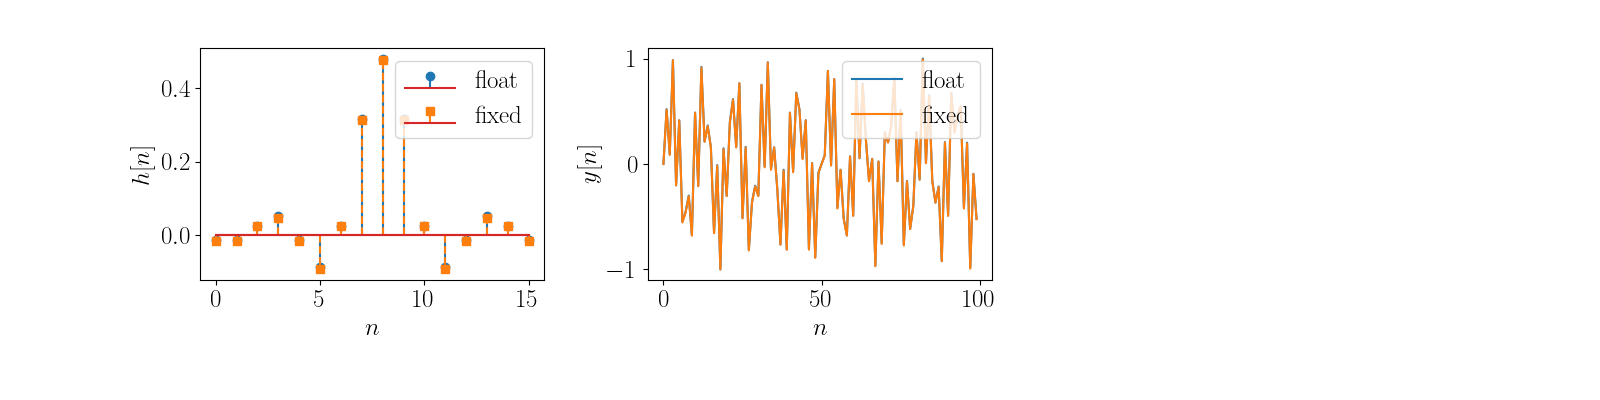

In [28]:
fig = plt.figure(figsize = (16,4))
plt.subplots_adjust(bottom=0.3, wspace = 0.3)
# Stem filter
ax1 = fig.add_subplot(1,3,1)
ax1.stem(nh, h, label = 'float')
ax1.set_xlabel(r'$n$')
ax1.set_ylabel(r'$h[n]$')

# Prikaz zaokruzenih koeficijenata
ax1.stem(nh, value_h, linefmt='C1--',markerfmt = 'C1s', label = 'fixed')
ax1.legend(loc = 'upper right');

# Stem output
ax2 = fig.add_subplot(1,3,2)
ax2.plot(n, x, label = 'float')
ax2.plot(n, value_x, label = 'fixed')
ax2.set_xlabel(r'$n$')
ax2.set_ylabel(r'$y[n]$')
ax2.legend(loc = 'upper right');

## Testiranje fxp realizacije polifaznog filtra

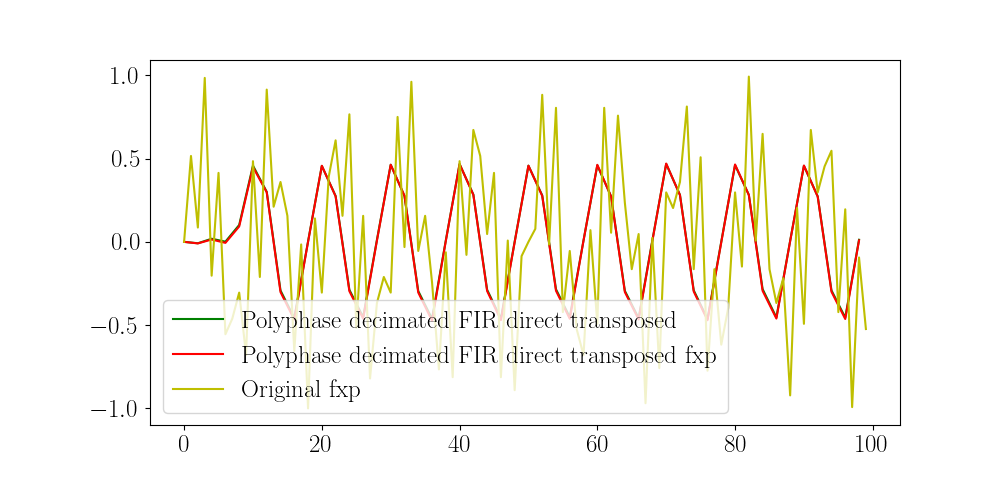

In [29]:
decimated_signal_my_fun_direct_transposed_fxp = polyphase_decimate_fir_direct_transposed_fxp(xFxp, hFxp, 2, outFxpFormat = None)
fig, axs = plt.subplots(figsize = [10, 5])
plt.subplots_adjust(bottom=0.15, left = 0.15)
plt.plot((n)[::2], decimated_signal_my_fun_direct_transposed, color = "g", label = "Polyphase decimated FIR direct transposed")
plt.plot((n)[::2], decimated_signal_my_fun_direct_transposed_fxp, "r", label = "Polyphase decimated FIR direct transposed fxp")
plt.plot(n, value_x, "y" , label = "Original fxp");
plt.legend();


## Rezultat fxp decimacije u Python-u sa kojim će se porediti rezultat iz VHDL-a

In [30]:
rez_py = (decimated_signal_my_fun_direct_transposed_fxp.get_val()*2**14).astype(np.int16)

In [31]:
print(rez_py)

[    0  -154   229  -100  1514  7358  4872 -4941 -7655     6  7484  4479
 -4850 -7552   119  7584  4529 -4982 -7759    83  7652  4623 -4833 -7703
   -25  7491  4520 -4809 -7567   138  7577  4454 -4936 -7636   114  7702
  4596 -4886 -7711   -42  7612  4609 -4820 -7545    78  7505  4445 -4908
 -7589   141]


## Zapisivanje ulaznog signala i koeficijenata u .txt fajl koji će se koristiti u VHDL-u

In [32]:
num_values = 0
NUM_ELEMENTS = len(value_x)
value_x_scaled = (value_x*2**7).astype(np.int16)
x1 = np.zeros(NUM_ELEMENTS).astype(np.int16)
with open("input_signal_integer_for_vhdl.txt", "w") as output_file:
    # Write to file
    for i in range(len(x1)):
        # Write to file
        output_file.write(f"{int(value_x_scaled[i])}\n")

In [33]:
num_values = 0
NUM_ELEMENTS = len(value_h)
value_h_scaled = (value_h*2**7).astype(np.int16)
x1 = np.zeros(NUM_ELEMENTS).astype(np.int16)
with open("coefficients_integer_for_vhdl.txt", "w") as output_file:
    # Write to file
    for i in range(len(x1)):
        # Write to file
        output_file.write(f"{int(value_h_scaled[i])}\n")

# 2.2 Implementacija u VHDL-u

## Stablo koeficijenata koje je dobijeno RAG postupkom prikazano je na slici u prilogu

<img src="images/coefficients.PNG" width="800"/>

In [34]:
num_phases = 2
nf_filter = value_h_scaled
polyphase_sections = [nf_filter[i::num_phases] for i in range(num_phases)]
h0 = polyphase_sections[0]
h1 = polyphase_sections[1]
print(h0)
print(h1)

[-2  3 -2  3 61  3 -2  3]
[ -2   6 -12  40  40 -12   6  -2]


## Rezultat decimacije u VHDL-u sačuvan je u .txt fajl i učitan u ovu skriptu

In [35]:
num_values = 0
NUM_ELEMENTS = 50
rez_vhdl = np.zeros(NUM_ELEMENTS).astype(np.int16)
with open("output_signal_decimate_rag_vhdl.txt", "r") as input_file:
    # Read from file
    for line in input_file:
        rez_vhdl[num_values] = int(line)
        num_values += 1
        if num_values == (NUM_ELEMENTS):
            break


## Poređenje sa Python realizacijom, moraju se oduzeti početne nule zbog pipeline-a

In [36]:
print(rez_vhdl[4:]-rez_py[:-4])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Simulacioni dijagram prikazan je na slici u prilogu

<img src="images/sim_dijag.PNG" width="800"/>

## Poređenje rezultata koji su dobijeni poslije sinteze

In [37]:
num_values = 0
NUM_ELEMENTS = 50
rez_vhdl_post = np.zeros(NUM_ELEMENTS).astype(np.int16)
with open("output_signal_decimate_rag_vhdl_post.txt", "r") as input_file:
    # Read from file
    for line in input_file:
        rez_vhdl_post[num_values] = int(line)
        num_values += 1
        if num_values == (NUM_ELEMENTS):
            break

In [38]:
print(rez_vhdl_post[4:]-rez_py[:-4])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Simulacioni dijagram prikazan je na slici u prilogu

<img src="images/post_sint_dijag.PNG" width="800"/>

## Rezultati zauzeća resursa i brzina rada

## Bez jednog neophodnog stepena pipeline-a, nema zadvoljenja vremenskih parametara

<img src="images/without_pipeline_1_stage.PNG" width="800"/>

<img src="images/without_pipeline_1_stage_fmax.PNG" width="800"/>

## Sa neophodnim pipline-om ali bez registara u stablu

<img src="images/without_pipeline_fmax.PNG" width="800"/>

<img src="images/reg_without_pipeline.PNG" width="800"/>

## Sa registrima u stablu

<img src="images/pipeline_fmax.PNG" width="800"/>

<img src="images/reg_pipeline.PNG" width="800"/>